### データ読み込み、配列数確認
### python3

In [46]:
import csv

class Count_read:
    def __init__(self):
        self.seq = []
    
    def make_dic(self, lines=None):
        ks = ['name', 'sequence', 'optional', 'quality']
        return {k: v for k, v in zip(ks, lines)}
    
    def extract_sequences(self, file=None):
        n = 4
        with open(file, 'r') as fh:
            lines = []
            for line in fh:
                lines.append(line.rstrip())
                if len(lines) == n:
                    record = self.make_dic(lines)
        self.seq = []
        for i in range(len(lines)):
            if i%4 == 1:
                self.seq.append(lines[i])
        return self.seq
    
in_R1_seq = Count_read().extract_sequences("../raw_data/200714/in_S1_L001_R1_001.fastq")
in_R2_seq = Count_read().extract_sequences("../raw_data/200714/in_S1_L001_R2_001.fastq")

out_R1_seq = Count_read().extract_sequences("../raw_data/200714/out_S2_L001_R1_001.fastq")
out_R2_seq = Count_read().extract_sequences("../raw_data/200714/out_S2_L001_R2_001.fastq")

    
        
print("in  R1:{}, R2:{}".format(len(in_R1_seq),len(in_R2_seq)))
print("out-> -> R1:{}, R2:{}".format(len(out_R1_seq),len(out_R2_seq)))

in  R1:680176, R2:680176
out-> -> R1:1950083, R2:1950083


### R2を相補鎖に

In [47]:
def reverse(seq):
    cmp_R2 = []
    for i in range(len(seq)):
        R2_reverse = seq[i][::-1]
        R2_complement = R2_reverse.translate(str.maketrans({'A':'T','T':'A','G':'C','C':'G'}))
        cmp_R2.append(R2_complement)
    return cmp_R2

in_R2_cmp = reverse(in_R2_seq)
out_R2_cmp = reverse(out_R2_seq)

print("in -> R2:{}".format(len(in_R2_cmp)))
print("out -> R2:{}".format(len(out_R2_cmp)))

in -> R2:680176
out -> R2:1950083


### RBSの抜き出し
#### R1とR2が一致すれば保存

In [48]:
def count_RBS(R1, R2):
    b = 'ATTAAAG' # RBS前の配列
    RBS = []
    for i in range(len(R1)):
        R1_index = R1[i].find(b)
        R1_RBS = R1[i][(R1_index+len(b)):(R1_index+len(b))+7]

        R2_index = R2[i].find(b)
        R2_RBS = R2[i][(R2_index+len(b)):(R2_index+len(b))+7]

        if R1_RBS == R2_RBS:
            RBS.append(R1_RBS)
    return RBS

in_RBS = count_RBS(in_R1_seq, in_R2_cmp)
out_RBS = count_RBS(out_R1_seq, out_R2_cmp)

print("in -> RBSの総数:", len(in_RBS))
print("out -> RBSの総数:", len(out_RBS))

in -> RBSの総数: 520577
out -> RBSの総数: 1497214


### ファイルに出力

### output >= 100、0 <= translation rate <= 4

In [49]:
import math
import collections
from scipy import stats

c1 = collections.Counter(in_RBS)
c2 = collections.Counter(out_RBS)

sort_c1 = sorted(c1.items()) # in
sort_c2 = sorted(c2.items()) # out

def _ave(num):
    if 0<=num<=5:
        num = 2.5
    elif 6<=num<=10:
        num = 8
    elif 11<=num<=15:
        num = 13
    elif 16<=num<=20:
        num = 18
    elif 21<=num<=40:
        num = 30.5
    elif 41<=num<=60:
        num = 50.5
    elif 61<=num<=80:
        num = 70.5
    elif 81<=num<=100:
        num = 90.5
    elif 101<=num<=120:
        num = 110.5
    elif 121<=num<=150:
        num = 135.5
    elif 151<=num<=190:
        num = 170.5
    elif 191<=num<=230:
        num = 210.5
    elif 231<=num<=270:
        num = 250.5
    elif 271<=num<=300:
        num = 285.5
    elif 301<=num<=360:
        num = 330.5
    elif 361<=num<=400:
        num = 380.5
    elif 401<=num<=450:
        num = 425.5
    elif 451<=num<=530:
        num = 490.5
    elif 531<=num<=600:
        num = 565.5
    elif 601<=num<=700:
        num = 650.5
    elif 701<=num<=800:
        num = 750.5
    else:
        num = num
    return num

e = []
with open('../input/train.csv','w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['seq','in','out','translation_rate'])
    for i in range(len(sort_c2)):
        if sort_c2[i][1] >= 100:
            out_num = _ave(sort_c2[i][1])
            if sort_c2[i][0] in c1:
                in_num = _ave(c1[sort_c2[i][0]])
            else:
                in_num = _ave(0)
            translation_rate = math.log2(out_num / in_num)
            if 0 <= translation_rate <= 4:
                e.append(translation_rate)
                writer.writerow([sort_c2[i][0], in_num, out_num, translation_rate])

In [50]:
#データの確認
import pandas as pd
train = pd.read_csv('../input/train.csv')
train

,seq,in,out,translation_rate
0,AAAAAGA,110.5,330.5,1.580604
1,AAAACAC,170.5,330.5,0.954879
2,AAAACTG,70.5,425.5,2.593464
3,AAAACTT,110.5,110.5,0.000000
4,AAAAGGT,210.5,1331.0,2.660618
...,...,...,...,...
1639,TTTTGTG,285.5,1829.0,2.679492
1640,TTTTTCA,250.5,330.5,0.399840
1641,TTTTTGT,210.5,210.5,0.000000
1642,TTTTTTA,330.5,425.5,0.364509


In [51]:
#翻訳効率が高い7配列を取り出す
high_seq = train.sort_values('translation_rate',ascending=False).reset_index()[1:8]
basic_seq = list(high_seq['seq'])
basic_seq

['AGTAAGG', 'AGGACGA', 'TAATTGG', 'AGGGTTG', 'TTAGGTG', 'AAGCCGG', 'TTGTAAG']

In [52]:
for seven_seq in basic_seq:
    train[seven_seq] = seven_seq

train

,seq,in,out,translation_rate,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
0,AAAAAGA,110.5,330.5,1.580604,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
1,AAAACAC,170.5,330.5,0.954879,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
2,AAAACTG,70.5,425.5,2.593464,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
3,AAAACTT,110.5,110.5,0.000000,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
4,AAAAGGT,210.5,1331.0,2.660618,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
...,...,...,...,...,...,...,...,...,...,...,...
1639,TTTTGTG,285.5,1829.0,2.679492,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
1640,TTTTTCA,250.5,330.5,0.399840,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
1641,TTTTTGT,210.5,210.5,0.000000,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG
1642,TTTTTTA,330.5,425.5,0.364509,AGTAAGG,AGGACGA,TAATTGG,AGGGTTG,TTAGGTG,AAGCCGG,TTGTAAG


In [53]:
train.to_csv('../input/train_data2.csv', index=False)

### enrichment ヒストグラム

1644
<class 'list'>


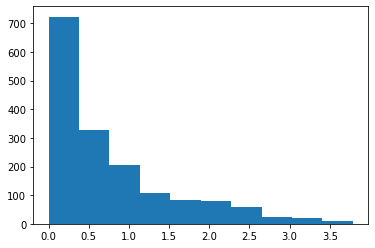

In [54]:
print(len(e))
print(type(e))

# グラフ描画のためmatplotlibのpyplotをインポート
import matplotlib.pyplot as plt
from scipy import stats

# ヒストグラムを描画する
plt.hist(e);

(1644,)
<class 'list'>
(1644,)
<class 'numpy.ndarray'>


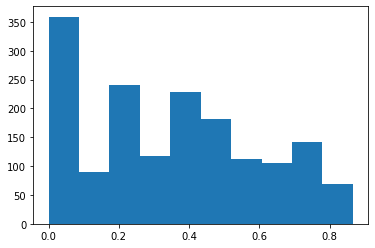

In [55]:
from scipy import stats
import numpy as np

print(np.shape(e))
print(type(e))
et, lmbda = stats.yeojohnson(e)
print(np.shape(et))
print(type(et))
plt.hist(list(et));